In [129]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight

import warnings
warnings.filterwarnings("ignore")

### Loading data

In [87]:
mutation_data = pd.read_csv("combined_mutation_matrix_full.csv")
mutation_data = mutation_data.dropna(axis=1, how='any')
y = pd.read_csv("disease_ids.csv")

mutation_data['disease_name'] = mutation_data['case'].map(y.set_index('case_id')['tumor_code'])
mutation_data = mutation_data.dropna(subset=['disease_name'])
mutation_data = mutation_data.drop(columns=['case'])
X = mutation_data.drop(columns=["disease_name"])
X.dropna(axis=1, inplace=True)
X = X.drop("worst_class_overall", axis=1, errors='ignore')
y = mutation_data['disease_name'].astype('category')
y = y.cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X.head()

,t_alt_A1BG,t_alt_A1CF,t_alt_A2M,t_alt_A2ML1,t_alt_A4GALT,t_alt_A4GNT,t_alt_AAAS,t_alt_AACS,t_alt_AADACL3,t_alt_AADACL4,...,t_alt_ZSWIM4,t_alt_ZSWIM5,t_alt_ZSWIM6,t_alt_ZSWIM8,t_alt_ZSWIM9,t_alt_ZWILCH,t_alt_ZXDC,t_alt_ZYG11A,t_alt_ZZEF1,t_alt_ZZZ3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Helper functions

In [107]:
def print_metrics(model, X_test_selected, y_test):
    y_pred = model.predict(X_test_selected)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

def plot_confusion_matrix(model, X_test_selected, y_test):
    plt.figure(figsize=(6, 5))
    short_labels = ['ALL', 'AML']
    ConfusionMatrixDisplay.from_estimator(model, X_test_selected, y_test, display_labels=short_labels, cmap='Blues')
    plt.title("Confusion Matrix - Tuned Random Forest")
    plt.show()

def plot_feature_importance(model, feature_names, top_n=15):
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print("\nTop features:")
    print(feat_imp.head(10))
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp.head(top_n).values, y=feat_imp.head(top_n).index, palette='plasma')
    plt.title(f"Top {top_n} Feature Importances - Random Forest")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

def plot_roc_curve(model, X_test_selected, y_test):
    if len(model.classes_) == 2:
        y_prob = model.predict_proba(X_test_selected)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='darkorange')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title("ROC Curve - Tuned Random Forest")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

## Model 1: Random forest 🌲

In [89]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print_metrics(rf, X_test, y_test)

Accuracy: 0.7561374795417348

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.45      0.61       259
           1       0.71      0.98      0.82       352

    accuracy                           0.76       611
   macro avg       0.83      0.72      0.72       611
weighted avg       0.81      0.76      0.73       611



<Figure size 600x500 with 0 Axes>

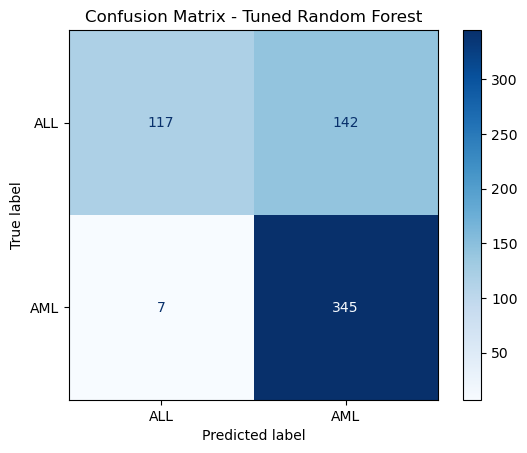

In [91]:
plot_confusion_matrix(rf, X_test, y_test)


Top features:
t_alt_NOTCH1    0.046788
t_alt_FBXW7     0.015508
t_alt_NPM1      0.011939
t_alt_NSD2      0.009436
t_alt_TTN       0.008998
t_alt_USP7      0.008613
t_alt_DST       0.007547
t_alt_PAX5      0.007164
t_alt_KIT       0.007069
t_alt_NRAS      0.007003
dtype: float64


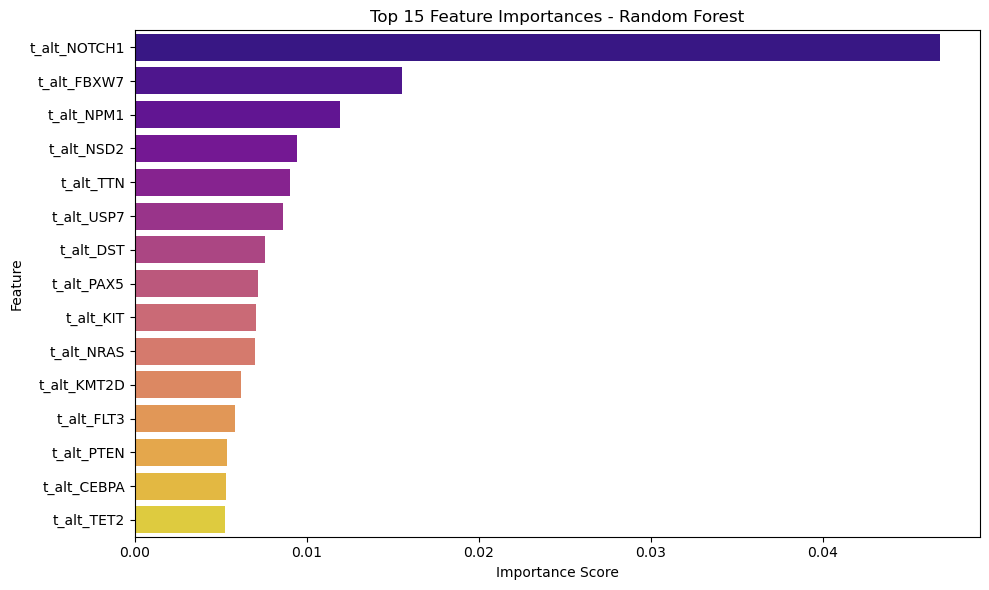

In [60]:
plot_feature_importance(rf, X_train.columns)

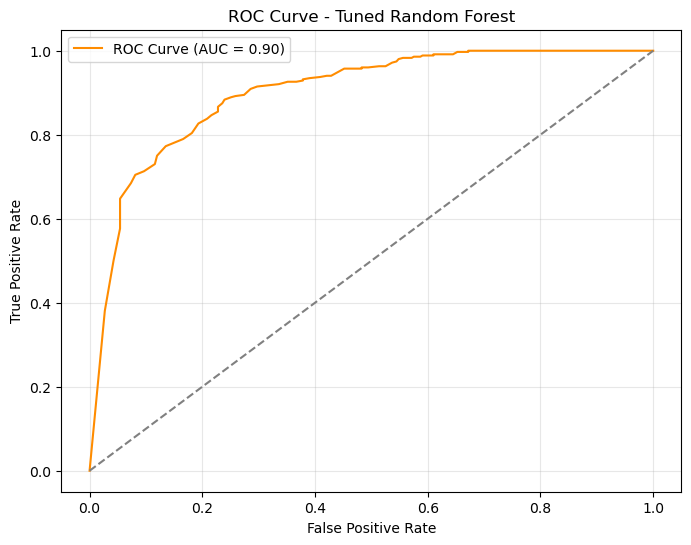

In [109]:
plot_roc_curve(rf, X_test, y_test)

## Model 2: XGBoost 🚀

In [95]:
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
print_metrics(xgb, X_test, y_test)

Accuracy: 0.806873977086743

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.62      0.73       259
           1       0.77      0.94      0.85       352

    accuracy                           0.81       611
   macro avg       0.83      0.78      0.79       611
weighted avg       0.82      0.81      0.80       611



<Figure size 600x500 with 0 Axes>

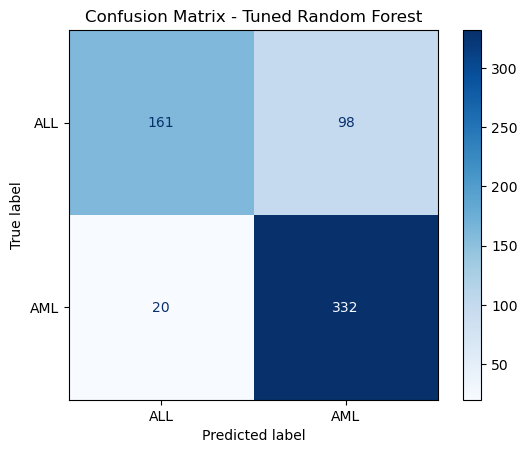

In [97]:
plot_confusion_matrix(xgb, X_test, y_test)


Top features:
t_alt_NOTCH1       0.070382
t_alt_NPM1         0.030442
t_alt_MUC16        0.021309
t_alt_KIT          0.018558
t_alt_IGHV1-69D    0.018463
t_alt_PAX5         0.017563
t_alt_DNMT3A       0.015891
t_alt_NSD2         0.015391
t_alt_TTN          0.014891
t_alt_FBXW7        0.014706
dtype: float32


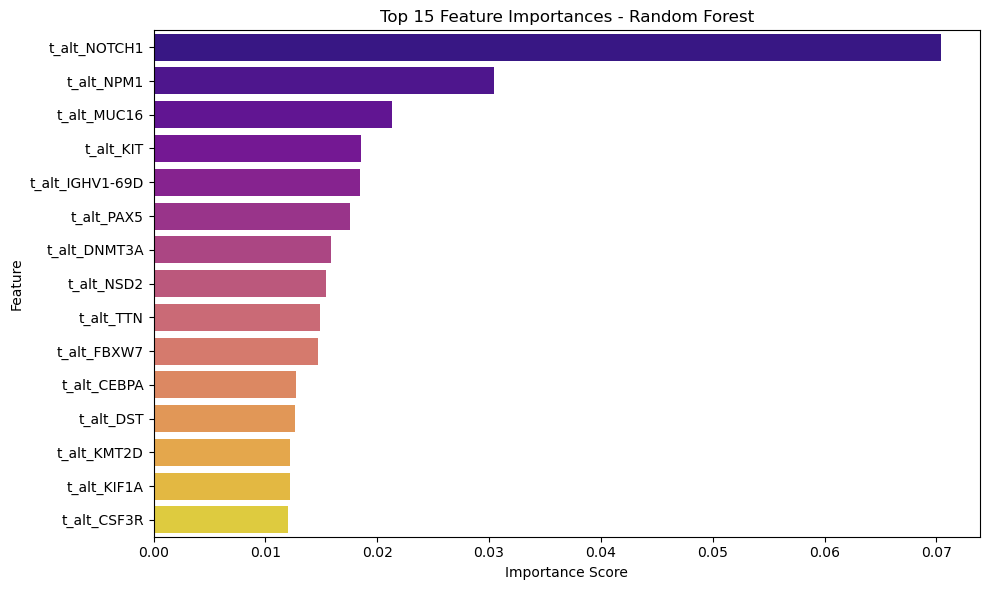

In [99]:
plot_feature_importance(xgb, X_train.columns)

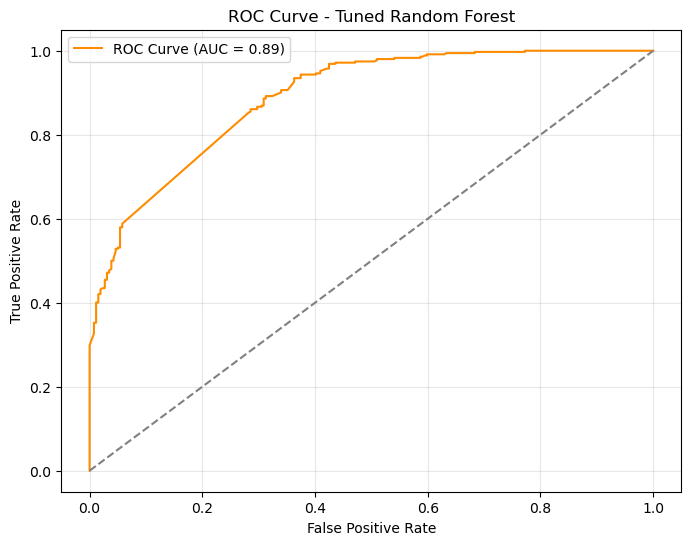

In [111]:
plot_roc_curve(xgb, X_test, y_test)

## Model 3: Tabnet 🤖

This model is in a seperate python file, because pytorch-tabnet would not work in a notebook.